In [17]:
from pyscf import gto, scf, fci
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal
from qiskit_ionq import IonQProvider
from qiskit.quantum_info import Statevector
import os
from qiskit.quantum_info import Pauli
from qiskit_algorithms import NumPyEigensolver
from qiskit.circuit.library import HGate , SdgGate
from qiskit import transpile
from scipy.optimize import differential_evolution

In [18]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()
  qubit_op = mapper.map(second_q_op)
  return qubit_op , mapper
# 고전값 비교용 FCI 
# H2 인경우로만 해뒀고, 거리 주면 에너지 계산할 수 있음. 
class ConvergenceReached(Exception):
    pass

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
# cost_func 외부에 전역 상태 저장
convergence_state = {
    "prev_cost": None,
    "streak": 0,
    "tol": 1e-4,        # ε: 변화 허용치
    "patience": 5,      # k: 연속 허용 횟수
    "trigger_stop": False,
}
def early_stop_callback(xk, convergence):
    return convergence_state["trigger_stop"]  # True 반환 시 중단됨



def cost_func(parameter, second_q_op, n_ptl, ansatz, backend,k):
    global convergence_state
    global cost_history_dict 
    params = ansatz.parameters 
    param_dict = dict(zip(params, parameter))
    qc = ansatz.assign_parameters(param_dict)
    qc.measure_all()
    job = backend.run(qc, shots=2000)
    result = job.get_probabilities()
    all_basis = []
    all_prob = []
    for bitstring, prob in result.items():
        count_ones = bitstring.count('1')
        half = len(bitstring) // 2
        left_ones = bitstring[:half].count('1')
        right_ones = bitstring[half:].count('1')
        if count_ones == n_ptl and left_ones==right_ones :
            all_basis.append(bitstring)
            all_prob.append(prob)

    all_basis = np.array(all_basis)
    all_prob = np.array(all_prob)
    top_indices = np.argsort(-all_prob)[:k]
    probable_basis = all_basis[top_indices]
    print("most probable_basis : ", probable_basis)

    n = len(probable_basis)
    H = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            basis_bra = probable_basis[i]
            basis_ket = probable_basis[j]
            inner_product = projection_hamiltonian(second_q_op, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 
            print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    eigvals, eigvecs = np.linalg.eig(H)
    Energy = np.min(eigvals)

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(Energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {Energy}]")

    prev = convergence_state["prev_cost"]
    if convergence_state["streak"] >= convergence_state["patience"]:
        print("✅ 조기 수렴 조건 충족: 최적화 강제 종료")
        raise ConvergenceReached()

    if prev is not None and abs(Energy - prev) < convergence_state["tol"]:
        convergence_state["streak"] += 1
    else:
        convergence_state["streak"] = 0
    convergence_state["prev_cost"] = Energy

    if convergence_state["streak"] >= convergence_state["patience"]:
        convergence_state["trigger_stop"] = True
        print("✅ 조기 수렴 조건 충족: 최적화 중단 예정")


    return Energy
def parsing(ferm_op):
    one_body_terms = []
    two_body_terms = []

    for label, coeff in ferm_op.items():
        ops = label.split()
        indices = [int(op[2:]) for op in ops]

        if len(ops) == 2:
            one_body_terms.append((coeff, indices))
        elif len(ops) == 4:
            two_body_terms.append((coeff, indices))
        # 그 외 (예: 항이 없는 상수) 등은 무시하거나 추가적으로 처리 가능

    return one_body_terms, two_body_terms

def projection_hamiltonian(second_q_op, basis_bra, basis_ket):
    single_terms, double_terms = parsing(second_q_op)

    Energy = 0
    for items in single_terms:
        p = items[1][0]
        q = items[1][1]
        if basis_bra[p] == str(1) and basis_ket[q] == str(1) :
            Energy += np.real(items[0])

    for items in double_terms:
        p = items[1][0]
        q = items[1][1]
        r = items[1][2]
        s = items[1][3]
        if basis_bra[p] == str(1) and basis_bra[q] == str(1) and basis_ket[r] == str(1) and basis_ket[s] == str(1) :
            Energy += np.real(items[0])
    return Energy
    #for item in pauli_terms:

In [19]:
api_key = "7IMO85iuzmzAAgri4osG5BPTeCFXrKoM"
provider = IonQProvider(api_key)
simulator_backend = provider.get_backend("simulator")
#simulator_backend = provider.get_backend("qpu.forte-1")

most probable_basis :  ['0101' '1010' '0110']
<0101|H|0101> = 0.453355430901752
<0101|H|1010> = 0.3618623995684628
<0101|H|0110> = -0.03214354602301736
<1010|H|0101> = 0.3618623995684628
<1010|H|1010> = -1.1612578363994666
<1010|H|0110> = -0.8280183957093756
<0110|H|0101> = -0.03214354602301736
<0110|H|1010> = -0.8280183957093756
<0110|H|0110> = -0.37651141126132837
Iters. done: 1 [Current cost: -1.7238847972066742]
most probable_basis :  ['0101' '0110' '1001']
<0101|H|0101> = 0.453355430901752
<0101|H|0110> = -0.03214354602301736
<0101|H|1001> = -0.03214354602301739
<0110|H|0101> = -0.03214354602301736
<0110|H|0110> = -0.37651141126132837
<0110|H|1001> = 0.3618623995684628
<1001|H|0101> = -0.03214354602301739
<1001|H|0110> = 0.3618623995684628
<1001|H|1001> = -0.37651141126132825
Iters. done: 2 [Current cost: -0.7383738108297911]
most probable_basis :  ['1010' '1001' '0110']
<1010|H|1010> = -1.1612578363994666
<1010|H|1001> = -0.8280183957093757
<1010|H|0110> = -0.8280183957093756
<10

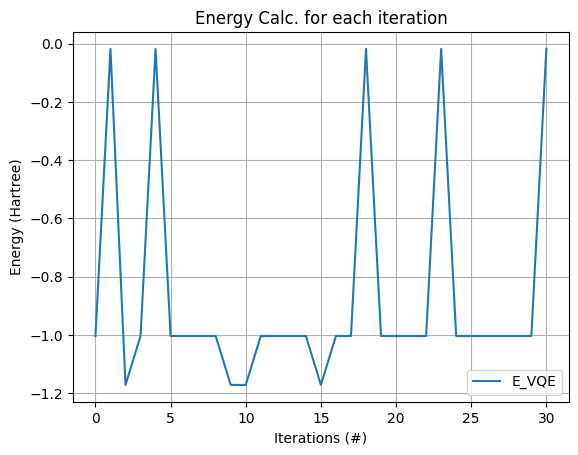

In [20]:
atoms = ["H", "H"]
basis = 'sto3g'
dist = 0.735
coords = [(0,0,0), (dist,0,0)]
charge = 0
multiplicity = 1
Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 

fermionic_hamiltonian = E_problem.hamiltonian
second_q_op = fermionic_hamiltonian.second_q_op()
repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
hamiltonian, mapper = fermion_to_qubit(E_problem, second_q_op, "JW")
H_op = hamiltonian.to_operator()
H_matrix = H_op.data
num_qubits = hamiltonian.num_qubits
num_particles = E_problem.num_particles
num_electrons = np.sum(num_particles)
num_spatial_orbitals = E_problem.num_spatial_orbitals


init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state).decompose()
#ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state)

pauli_basis = hamiltonian.paulis
coeffs = hamiltonian.coeffs
num_params = ansatz.num_parameters

""""
x0 = 2 * np.pi * np.random.random(num_params)

res = minimize(
    cost_func,
    x0,
    args=(second_q_op, num_electrons, ansatz, simulator_backend, 4),
    method="cobyla",
)

"""

bounds = [(0, 2*np.pi)] * num_params  # ansatz 파라미터 수에 따라 조절

try:
    res = differential_evolution(
        func=lambda w: cost_func(w, second_q_op, num_electrons, ansatz, simulator_backend,3 ),
        bounds=bounds,
        callback=early_stop_callback,
        polish=True,
    )
except ConvergenceReached:
    print("🔁 최적화가 조기 수렴 조건에 따라 종료되었습니다.")

plt.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"] + repulsion, label='E_VQE')
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
plt.xlabel("Iterations (#)")
plt.ylabel("Energy (Hartree)")
plt.title("Energy Calc. for each iteration")
plt.legend()
plt.grid()
plt.draw()